<a href="https://colab.research.google.com/github/NimishKmr030396/DataAnalystProjects/blob/main/delhivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import pandas as pd

'''
Loading csv file in colab notebook and converting timestamp columns into pandas datetime.
Concerned columns are: 1. trip_creation_time
                       2. od_start_time
                       3. od_end_time
                       4. cutoff_timestamp

'''
delhivery_data = '/content/drive/MyDrive/delhivery_data.csv'
df = pd.read_csv(delhivery_data)

In [6]:
df.dtypes
df_1 = pd.read_csv(delhivery_data, parse_dates = [1, 9, 10, 14])

In [7]:
# Extracting numerical columns:
num_cols = df_1.dtypes[(df_1.dtypes == 'int64') | (df_1.dtypes == 'float64')].index
num_cols

Index(['start_scan_to_end_scan', 'cutoff_factor',
       'actual_distance_to_destination', 'actual_time', 'osrm_time',
       'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor'],
      dtype='object')

In [8]:
# Missing_cols : source_name, destination_name.
df_1.isna().mean()[df_1.isna().mean()>0]

source_name         0.002023
destination_name    0.001802
dtype: float64

In [9]:
# Since corresponding %ages are significantly low, let's go for CCA and drop the missing records completely.
df_1.dropna(axis = 0, how = 'any', inplace = True)

In [10]:
# Number of sources and destinations corresponding to each unique trips.
src_des = df_1.groupby('trip_uuid').agg({'destination_center': 'nunique', 'source_center': 'nunique'}).reset_index(drop = False)

In [11]:
'''
Since a single trip can accomoate multiple delivery corresponding to different pairs of sources and destinations,
Segmentation is required for identification of a unique delivery.
'''
df_1['segment_key'] = df_1['trip_uuid'] + df_1['source_center'] + df_1['destination_center']

df_1.groupby('segment_key').ngroups
# Dataset consists of 26222 deliveries.

26222

In [12]:
'''
Grouping data on segment_key and computing the cumulative sum on columns: segment_actual_time,	segment_osrm_time, & segment_osrm_distance to
introduce 3 new fetaures, namely segment_actual_time_sum, segment_osrm_distance_sum & segment_osrm_time_sum.
'''

df_1[['segment_actual_time_sum','segment_osrm_distance_sum', 'segment_osrm_time_sum']] = df_1.groupby('segment_key').agg({'segment_actual_time': 'cumsum',
'segment_osrm_distance':'cumsum', 'segment_osrm_time': 'cumsum'})

In [13]:
# Creating a dictionary 'create_segment_dict' to store aggregations to be performed on different columns of data.(Unknown fields are not included.)

create_segment_dict = {
'data': 'first', 'trip_creation_time': 'first', 'route_schedule_uuid': 'first', 'route_type': 'first',
'trip_uuid': 'first', 'source_center': 'first', 'source_name': 'first',	'destination_center': 'first',	'destination_name': 'first',
'od_start_time': 'first',	'od_end_time': 'first',	'start_scan_to_end_scan': 'first', 'actual_distance_to_destination': 'last',
'actual_time': 'last', 'osrm_time': 'last',	'osrm_distance' : 'last', 'segment_actual_time_sum' : 'last',
'segment_osrm_distance_sum' : 'last', 'segment_osrm_time_sum' : 'last',
}

In [14]:
# Aggregation functions specified in the create_segment_dict are applied to each group of rows with the same segment_key.
segmented_data = df_1.groupby('segment_key').agg(create_segment_dict).reset_index(drop = False)

# segmented_data sorted by 1. segmented_key, 2. od_end_time in ascending order.
segmented_data.sort_values(by = ['segment_key', 'od_end_time'], ascending = True, inplace = True)

**Fetaure Engineering:**

In [15]:
segmented_data['od_time_diff_hour'] = (segmented_data['od_end_time'] - segmented_data['od_start_time'])
segmented_data['od_time_diff_hour'] = segmented_data['od_time_diff_hour'].dt.total_seconds() / 3600

In [16]:
# Extracting new features out of trip_creation_date: date, day, month & year.

segmented_data['trip_creation_date'] = segmented_data['trip_creation_time'].dt.date
segmented_data['trip_creation_day'] = segmented_data['trip_creation_time'].dt.day
segmented_data['trip_creation_month'] = segmented_data['trip_creation_time'].dt.month
segmented_data['trip_creation_year'] = segmented_data['trip_creation_time'].dt.year

In [17]:
# Defining function to extract state from place.
def state_name(series):
  state_name = series.split(' (')[1][:-1]
  return state_name

# Defining function to extract city from place.
def city_name(series):
  city_name = series.split(' (')[0].split('_')[0]
  return city_name

In [18]:
# Definfing columns city and state for sources & destinations.
segmented_data['source_city']  = segmented_data['source_name'].apply(lambda series: city_name(series))
segmented_data['source_state'] = segmented_data['source_name'].apply(lambda series: state_name(series))
segmented_data['destination_city']  = segmented_data['destination_name'].apply(lambda series: city_name(series))
segmented_data['destination_state'] = segmented_data['destination_name'].apply(lambda series: state_name(series))

In [19]:
# Enumerating columns & their corresponding indices on segmented_data:
columns_list = list(enumerate(segmented_data.keys()))
columns_list

# Reordering columns:
new_col_index = [0, 3, 4, 5, 2, 21, 22, 23, 24, 6, 7, 25, 26, 8, 9, 27, 28, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 1]
segmented_data = segmented_data.iloc[:, new_col_index]

In [20]:
# Creating a dictionary 'create_trip_dict' to store aggregations to be performed on different columns of data.
create_trip_dict = {'segment_key': 'count',	'data': 'first',	'trip_creation_time': 'first',	'route_schedule_uuid': 'first',	'route_type': 'first','trip_creation_time': 'first',
                    'trip_creation_date': 'first',	'trip_creation_day': 'first',	'trip_creation_month': 'first',	'trip_creation_year': 'first', 'source_center'	: 'last', 'source_name': 'last',	'source_city': 'last',	'source_state': 'last', 'destination_center': 'first',	'destination_name': 'first',
                    'destination_city': 'first',	'destination_state': 'first', 'od_start_time': 'last', 'od_end_time': 'first',
                    'start_scan_to_end_scan': 'sum',	'actual_distance_to_destination': 'sum',	'actual_time': 'sum',
                    'osrm_time': 'sum',	'osrm_distance': 'sum',	'segment_actual_time_sum': 'sum',	'segment_osrm_distance_sum': 'sum',
                    'segment_osrm_time_sum': 'sum',	'od_time_diff_hour': 'sum'}

In [21]:
# Aggregation functions specified in the create_trip_dict are applied to each group of rows with the same trip_uuid.
trip_data = segmented_data.groupby('trip_uuid').agg(create_trip_dict).reset_index()

# Renaming columns:
trip_data.columns = ['trip_uuid', 'DeliveryCount', 'data', 'trip_creation_time',
       'route_schedule_uuid', 'route_type', 'trip_creation_date',	'trip_creation_day',	'trip_creation_month',	'trip_creation_year', 'firstSource_center', 'firstSource_name',
       'firstSouce_City', 'firstSource_state', 'endDestination_center', 'endDestination_name', 'destination_city',	'destination_state',
       'od_start_time',	'od_end_time', 'start_scan_to_end_scan',
       'actual_distance_to_destination', 'actual_time_sum', 'osrm_time_sum',
       'osrm_distance_sum', 'segment_actual_time_sum', 'segment_osrm_distance_sum',
       'segment_osrm_time_sum', 'od_time_diff_hour']

In [22]:
# Extracting numerical columns:
num_cols = trip_data.keys()[18:]

# Defining time and distance columns:
time_cols, dist_cols = num_cols[[0, 1, 2, 4, 5, 7, 9, 10]], num_cols[[3, 6, 8]]

***Outlier Detection***:

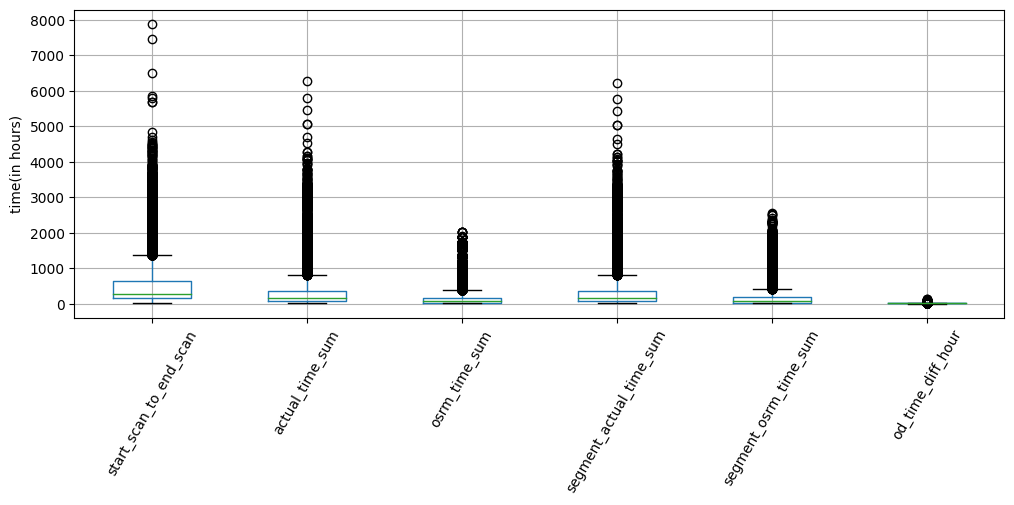

In [23]:
trip_data[time_cols].boxplot(rot = 60, figsize = (12, 4))
plt.ylabel('time(in hours)')
plt.show()

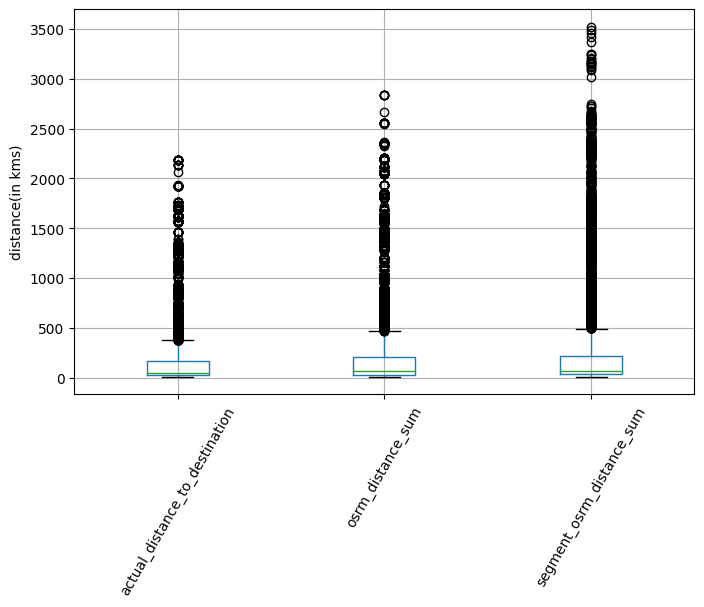

In [24]:
trip_data[dist_cols].boxplot(rot = 60, figsize = (8, 5))
plt.ylabel('distance(in kms)')
plt.show()

In [25]:
# Creating a deep copy of trip_data:
trip_data_1 = trip_data

***Outlier's treatment***:

In [26]:
'''
From Graphical Analysis(box plot), the minimum attained for all numerical features is 0.
Considering a statistical dispersion of 1.5, we are defining upper_bound for each feature and values beyond upper_bound are treated accordingly.'''

for cols in num_cols:
  Q1, Q2, Q3 = np.percentile(trip_data_1[cols], 25), np.percentile(trip_data_1[cols], 50), np.percentile(trip_data_1[cols], 75)
  IQR = Q3 - Q1
  upper_bound = Q3 + IQR * 1.5
  trip_data_1.loc[trip_data_1[cols] > upper_bound, cols] = upper_bound


**One Hot Encoding on Binary Categorical features:**

*1. route_type*

*2. data*

In [27]:
# One hot Encoding on categorical features: route_type & data:

for cat_cols in ['route_type', 'data']:
  val_1, val_2 = trip_data_1[cat_cols].unique()[0], trip_data_1[cat_cols].unique()[1]
  trip_data_1[cat_cols] = trip_data_1[cat_cols].map({val_1: 0, val_2: 1})

***Normalize/ Standardize the numerical features:***

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
num_cols = num_cols[2:]

In [30]:
trip_data_1_standardized = StandardScaler().fit_transform(trip_data_1[num_cols])

In [31]:
trip_data_1_standardized_df = pd.DataFrame(trip_data_1_standardized, columns=num_cols)

In [32]:
trip_data_1_standardized_df

,start_scan_to_end_scan,actual_distance_to_destination,actual_time_sum,osrm_time_sum,osrm_distance_sum,segment_actual_time_sum,segment_osrm_distance_sum,segment_osrm_time_sum,od_time_diff_hour
0,2.223281,2.281370,2.141392,2.255661,2.271659,2.141970,2.254747,2.259726,2.224379
1,-0.666050,-0.302255,-0.460518,-0.400293,-0.358333,-0.462704,-0.401315,-0.473161,-0.663671
2,2.223281,2.281370,2.141392,2.255661,2.271659,2.141970,2.254747,2.259726,2.224379
3,-0.862520,-0.782032,-0.784792,-0.856583,-0.804880,-0.781485,-0.819635,-0.855766,-0.862595
4,0.652752,0.162532,0.303841,0.021561,0.062619,0.310923,0.005882,-0.082749,0.652576
...,...,...,...,...,...,...,...,...,...
14782,-0.476948,-0.434377,-0.692143,-0.451948,-0.437827,-0.692070,-0.527074,-0.496586,-0.476272
14783,-0.960754,-0.796264,-0.931487,-0.882411,-0.829393,-0.929212,-0.844276,-0.894807,-0.960453
14784,-0.074185,-0.597789,0.076077,-0.572478,-0.537190,0.081556,-0.266690,-0.293572,-0.073870
14785,-0.255920,0.224850,0.006590,0.555334,0.228586,-0.007858,0.505038,0.744926,-0.254377


In [33]:
from scipy.stats import ttest_ind

# ***Actual_time aggregated value and OSRM time aggregated***

  Assumptions of Student's t test:
  1. Normality
  2. Homogeneity of Variances (Equal Variance)
  3. Independence
  4. Random Sampling


#  GRAPHICAL ANALYSIS:

<ipython-input-34-908f5e82f927>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['actual_time_sum'], color = 'blue', shade = True)
<ipython-input-34-908f5e82f927>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['osrm_time_sum'], color = 'red', shade = True)


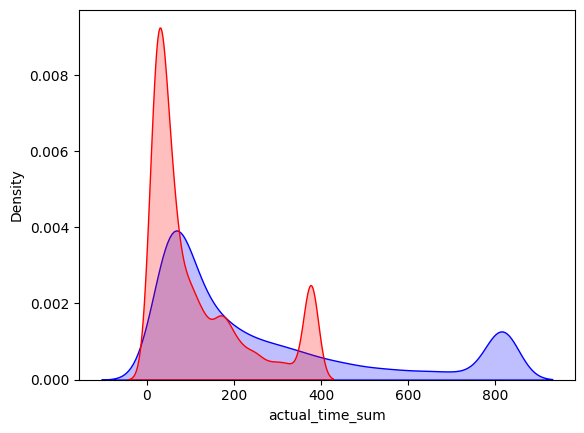

In [34]:
# Normality Test:
import seaborn as sns
from matplotlib import pyplot as plt
sns.kdeplot(trip_data_1['actual_time_sum'], color = 'blue', shade = True)
sns.kdeplot(trip_data_1['osrm_time_sum'], color = 'red', shade = True)
plt.show()

In [35]:
# Homogeneity of Variances (Equal Variance):
from scipy.stats import levene

l_stats, p_val = levene(trip_data_1['actual_time_sum'], trip_data_1['osrm_time_sum'])
l_stats, p_val
# Since p_val is below 0.05, We can assume both the times have different variances & we are going for Welch's Student T test.

(3122.240599088414, 0.0)

In [36]:
'''From Graphical analysis, our assumptiuon of Normality has failed and we will go for a more roubust test that takes care
   of violations of normality i.e, Welch's T Student's test'''

"From Graphical analysis, our assumptiuon of Normality has failed and we will go for a more roubust test that takes care\n   of violations of normality i.e, Welch's T Student's test"

In [37]:
''' Considering significance level of 5%:
    Null Hypothesis(H0): Actual Time and OSMR time taken for deliveries is similar.
    Alternate Hypothesis(H1): Actual Time and OSMR time taken for deliveries are significantly different from each other.
'''

significance_level = 0.05

t_stats, p_val = ttest_ind(trip_data_1['actual_time_sum'], trip_data_1['osrm_time_sum'], equal_var = False)
print(f'Test Statistics: {t_stats}, p_value = {p_val}')
if p_val > significance_level:
  print('We fails to reject Null hypothesis.\nActual_time_aggreagted & osmr_time_aggregated are almost similar and difference between them is insignificant.')
else:
  print('Null Hypothesis is rejected/nActual time taken and OSMR parameter is significanlty different from each other.')

Test Statistics: 63.30545280574021, p_value = 0.0
Null Hypothesis is rejected/nActual time taken and OSMR parameter is significanlty different from each other.


\# ***Actual_time aggregated value and segment actual time aggregated***

# GRAPHICAL ANALYSIS

<ipython-input-38-ab2e37786ea4>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['actual_time_sum'], color = 'blue', shade = True)
<ipython-input-38-ab2e37786ea4>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['segment_actual_time_sum'], color = 'red', shade = True)


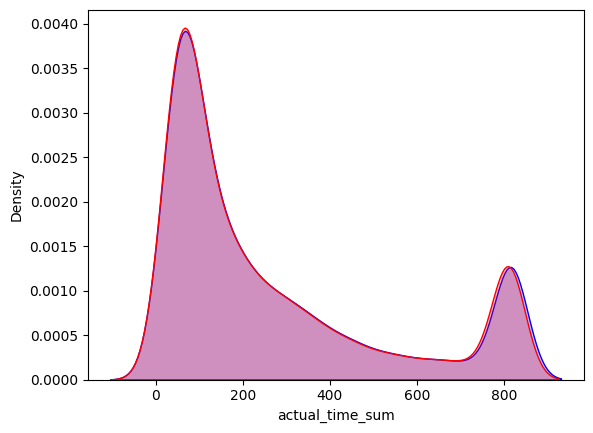

In [38]:
# Normality Test:
import seaborn as sns
from matplotlib import pyplot as plt
sns.kdeplot(trip_data_1['actual_time_sum'], color = 'blue', shade = True)
sns.kdeplot(trip_data_1['segment_actual_time_sum'], color = 'red', shade = True)
plt.show()

In [39]:
# Homogeneity of Variances (Equal Variance):
from scipy.stats import levene

l_stats, p_val = levene(trip_data_1['actual_time_sum'], trip_data_1['segment_actual_time_sum'])
l_stats, p_val
# Since p_val is beyond 0.05, We can assume both the times have similar variances.

(0.33495915317340386, 0.5627578554257575)

In [40]:
''' Considering significance level of 5%:
    Null Hypothesis(H0): Actual time aggregated and Segment actual time aggreagted taken for deliveries are similar.
    Alternate Hypothesis(H1): Actual Time aggregated and Segment actual time aggreagted for deliveries are significantly different from each other.
'''

significance_level = 0.05

t_stats, p_val = ttest_ind(trip_data_1['actual_time_sum'], trip_data_1['segment_actual_time_sum'])
print(f'Test Statistics: {t_stats}, p_value = {p_val}')
if p_val > significance_level:
  print('\nWe fails to reject Null hypothesis.\nActual_time_aggreagted & segment_actual_time_aggregated are almost similar and difference between them is insignificant.')
else:
  print('Null Hypothesis is rejected/nTime taken in actual time aggregated and segment actual time aggregated are significanlty different from each other.')

Test Statistics: 0.7566645099710447, p_value = 0.44925691028431425

We fails to reject Null hypothesis.
Actual_time_aggreagted & segment_actual_time_aggregated are almost similar and difference between them is insignificant.


 ***OSMR distance aggregated value and segment OSMR distance aggregated***

# GRAPHICAL ANALYSIS

<ipython-input-41-ff55b67a0a71>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['osrm_distance_sum'], color = 'blue', shade = True)
<ipython-input-41-ff55b67a0a71>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['segment_osrm_distance_sum'], color = 'red', shade = True)


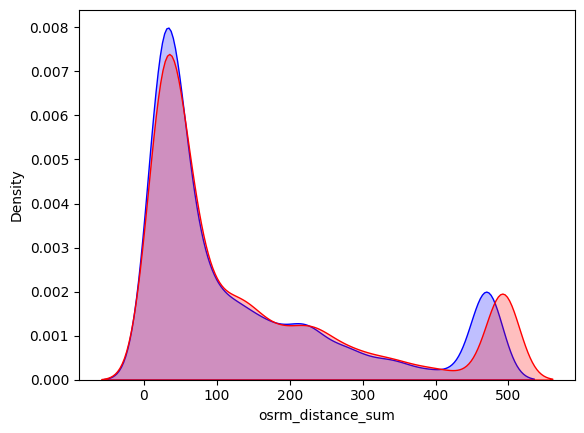

In [41]:
# Normality Test:
import seaborn as sns
from matplotlib import pyplot as plt
sns.kdeplot(trip_data_1['osrm_distance_sum'], color = 'blue', shade = True)
sns.kdeplot(trip_data_1['segment_osrm_distance_sum'], color = 'red', shade = True)
plt.show()

In [42]:
# Homogeneity of Variances (Equal Variance):
from scipy.stats import levene

l_stats, p_val = levene(trip_data_1['osrm_distance_sum'], trip_data_1['segment_osrm_distance_sum'])
l_stats, p_val
# Since p_val is below 0.05, We can assume both the times values have significantly different variances.

(15.103254314189016, 0.00010200956072621835)

In [43]:
''' Considering significance level of 5%:
    Null Hypothesis(H0): OSMR distance aggregated and Segment OSMR distance aggreagted for deliveries are similar.
    Alternate Hypothesis(H1): OSMR distance aggregated and Segment OSMR distance aggregated for deliveries are significantly different from each other.
'''

significance_level = 0.05

t_stats, p_val = ttest_ind(trip_data_1['osrm_distance_sum'], trip_data_1['segment_osrm_distance_sum'], equal_var = False)
print(f'Test Statistics: {t_stats}, p_value = {p_val}')
if p_val > significance_level:
  print('''\nWe fails to reject Null hypothesis. OSMR distance aggregated & segment OSMR distance aggregated are almost similar and difference between them is insignificant.''')
else:
  print('Null Hypothesis is rejected\nOSMR distance aggregated and segment OSMR distance aggregated are significanlty different from each other.')

Test Statistics: -4.735638441691023, p_value = 2.193806542256223e-06
Null Hypothesis is rejected
OSMR distance aggregated and segment OSMR distance aggregated are significanlty different from each other.


 ***OSMR time aggregated value and segment OSMR time aggregated***

# GRAPHICAL ANALYSIS

<ipython-input-44-b8d4e3eb6fbb>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['osrm_time_sum'], color = 'blue', shade = True)
<ipython-input-44-b8d4e3eb6fbb>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trip_data_1['segment_osrm_time_sum'], color = 'red', shade = True)


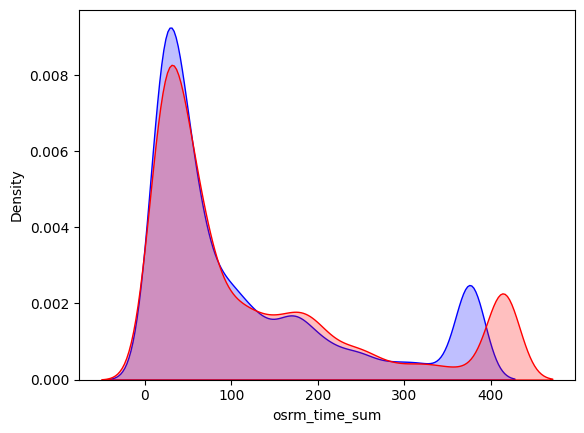

In [44]:
# Normality Test:
import seaborn as sns
from matplotlib import pyplot as plt
sns.kdeplot(trip_data_1['osrm_time_sum'], color = 'blue', shade = True)
sns.kdeplot(trip_data_1['segment_osrm_time_sum'], color = 'red', shade = True)
plt.show()

In [45]:
# Homogeneity of Variances (Equal Variance):
from scipy.stats import levene

l_stats, p_val = levene(trip_data_1['osrm_time_sum'], trip_data_1['segment_osrm_time_sum'])
l_stats, p_val
# Since p_val is below 0.05, both the times have significantly different variances.

(57.4976571795887, 3.4829573626719775e-14)

In [46]:
''' Considering significance level of 5%:
    Null Hypothesis(H0): OSMR time aggregated and Segment OSMR time aggreagted for deliveries are similar.
    Alternate Hypothesis(H1): OSMR time aggregated and Segment OSMR time aggregated for deliveries are significantly different from each other.
'''

significance_level = 0.05

t_stats, p_val = ttest_ind(trip_data_1_standardized_df['osrm_time_sum'], trip_data_1_standardized_df['segment_osrm_time_sum'], equal_var = False)
print(f'Test Statistics: {t_stats}, p_value = {p_val}')
if p_val > significance_level:
  print('\nWe fails to reject Null hypothesis.\nOSMR time aggregated & Segment OSMR time aggregated are almost similar and difference between them is insignificant.')
else:
  print('Null Hypothesis is rejected/nOSMR time aggregated and Segment OSMR time aggregated are significanlty different from each other.')

Test Statistics: 1.322118743893775e-15, p_value = 0.9999999999999989

We fails to reject Null hypothesis.
OSMR time aggregated & Segment OSMR time aggregated are almost similar and difference between them is insignificant.


#  *BUSINESS INSIGHTS:*

In [47]:
# Total number of trips made are 14,787

trips_made = trip_data_1.groupby(['firstSource_state', 'destination_state']).agg({'trip_uuid': 'nunique'}).reset_index(drop = False).sort_values(by = ['firstSource_state', 'trip_uuid'], ascending = [True, False])
trips_made

,firstSource_state,destination_state,trip_uuid
0,Andhra Pradesh,Andhra Pradesh,399
3,Andhra Pradesh,Telangana,26
1,Andhra Pradesh,Karnataka,2
2,Andhra Pradesh,Orissa,1
5,Arunachal Pradesh,Assam,27
...,...,...,...
151,West Bengal,West Bengal,610
148,West Bengal,Haryana,11
147,West Bengal,Assam,8
149,West Bengal,Jharkhand,6


In [48]:
# Total Deliveries contained in data is 26,222.

deliveries_made = segmented_data.groupby(['source_state', 'destination_state']).agg({'segment_key': 'nunique'}).reset_index().sort_values(by = ['source_state', 'segment_key'], ascending = [True, False])
deliveries_made.sort_values(by = 'segment_key', ascending = False)

,source_state,destination_state,segment_key
98,Maharashtra,Maharashtra,3255
72,Karnataka,Karnataka,3158
129,Tamil Nadu,Tamil Nadu,2021
144,Uttar Pradesh,Uttar Pradesh,1526
137,Telangana,Telangana,1315
...,...,...,...
63,Jharkhand,Assam,1
32,Gujarat,Daman & Diu,1
139,Tripura,Tripura,1
132,Telangana,Haryana,1


In [49]:
''' Maximum number of deliveries made by states among themshelves are:
    1. Maharashtra
    2. Karnataka
    3. Tamil Nadu
    4. Uttar Pradesh
    5. Telangana
'''

' Maximum number of deliveries made by states among themshelves are:\n    1. Maharashtra\n    2. Karnataka\n    3. Tamil Nadu\n    4. Uttar Pradesh\n    5. Telangana\n'

In [50]:
# Top 5 busiest routes are:
segmented_data.groupby('route_schedule_uuid').agg({'segment_key': 'nunique'}).reset_index().sort_values(by = 'segment_key', ascending = False)[:5]

,route_schedule_uuid,segment_key
1444,thanos::sroute:f8c83fd0-6554-44f3-9408-32465bd...,111
1198,thanos::sroute:d26c2fa7-68f9-4eb7-ba6e-ef9eb67...,107
1172,thanos::sroute:cdf7bbbb-8fb5-4bd5-96d9-162fcf3...,103
281,thanos::sroute:34330d20-1386-457b-8373-f94cc2f...,100
294,thanos::sroute:36941a6b-0e90-4582-a95a-96666dc...,99


In [51]:
deliveries_made_per_day = segmented_data.groupby('trip_creation_date')['segment_key'].nunique().sort_values(ascending = False).reset_index()
deliveries_made_per_day

,trip_creation_date,segment_key
0,2018-09-18,1373
1,2018-09-21,1358
2,2018-09-13,1320
3,2018-09-20,1319
4,2018-09-25,1319
5,2018-09-14,1296
6,2018-09-15,1293
7,2018-09-17,1293
8,2018-09-12,1290
9,2018-09-22,1276


In [52]:
# Average distance travelled during each route to complete the trip.
trip_data_1.groupby('trip_uuid').agg({'actual_distance_to_destination': 'mean'}).reset_index()

,trip_uuid,actual_distance_to_destination
0,trip-153671041653548748,374.812497
1,trip-153671042288605164,73.186911
2,trip-153671043369099517,374.812497
3,trip-153671046011330457,17.175274
4,trip-153671052974046625,127.448500
...,...,...
14782,trip-153861095625827784,57.762332
14783,trip-153861104386292051,15.513784
14784,trip-153861106442901555,38.684839
14785,trip-153861115439069069,134.723836


In [53]:
# Average time taken by each route to complete the trip(in minutes).
trip_data_1.groupby('trip_uuid').agg({'actual_time_sum': 'mean'}).reset_index()

,trip_uuid,actual_time_sum
0,trip-153671041653548748,817.0
1,trip-153671042288605164,143.0
2,trip-153671043369099517,817.0
3,trip-153671046011330457,59.0
4,trip-153671052974046625,341.0
...,...,...
14782,trip-153861095625827784,83.0
14783,trip-153861104386292051,21.0
14784,trip-153861106442901555,282.0
14785,trip-153861115439069069,264.0


In [54]:
trip_data_1.groupby('route_type')['actual_time_sum'].mean()
# average time during Carting: 473 mins
# average time during Full Truck Loading: 123 mins

route_type
0    473.231593
1    123.001347
Name: actual_time_sum, dtype: float64

# ***Recommendations to business:***

In [55]:
states_with_minimum_deliveries = trips_made.groupby('firstSource_state').agg({'trip_uuid': 'sum'}).sort_values(by = 'trip_uuid', ascending= True).head(10).index
states_with_minimum_deliveries

Index(['Tripura', 'Nagaland', 'Mizoram', 'Pondicherry', 'Meghalaya',
       'Dadra and Nagar Haveli', 'Jammu & Kashmir', 'Chhattisgarh',
       'Arunachal Pradesh', 'Goa'],
      dtype='object', name='firstSource_state')

# *Non Adopting States or Untapped market*:

1. Tripura
2. Nagaland
3. Mizoram
4. Pondicherry
5. Meghalaya
6. Dadra and Nagar Haveli
7. Jammu & Kashmir
8. Chhattisgarh
9. Arunachal Pradesh
10. Goa


# ***RECOMMENDATIONS:***

# 1. Partnerships and Alliances:

  Form partnerships with local businesses, influencers, or organizations to increase visibility and credibility in the region.

# 2. Invest in Infrastructure:

  Improve the infrastructure needed to deliver your services in the target regions.

# 3. Market Research:

Conduct thorough market research to understand the local needs, preferences, and challenges in the target regions.

In [56]:
time_taking_routes = trip_data_1.groupby('trip_uuid').agg({'actual_time_sum': 'mean'}).reset_index().sort_values(by = 'actual_time_sum', ascending = False).head(10)['trip_uuid'].values
time_taking_routes

array(['trip-153671041653548748', 'trip-153770156233988900',
       'trip-153769924445481836', 'trip-153707293708383893',
       'trip-153769738496708146', 'trip-153818041360177160',
       'trip-153687211942696088', 'trip-153707307438150188',
       'trip-153687200804882587', 'trip-153769645833352024'], dtype=object)

# ***Maximum time taking routes:***

1.  trip-153671041653548748
2.  trip-153770156233988900
3.  trip-153769924445481836
4.  trip-153707293708383893
5.  trip-153769738496708146
6.  trip-153818041360177160
7.  trip-153687211942696088
8.  trip-153707307438150188
9.  trip-153687200804882587
10. trip-153769645833352024


# ***Recommnedations for routes taking maximum time:***

1. Route Optimization:
   Regularly update and adjust routes to accommodate changes in traffic   
   patterns or delivery demand.

2. Real-Time Tracking and Monitoring:
  Implement real-time tracking systems to monitor the progress of delivery vehicles.

  Provide customers with accurate and real-time updates on the status of their deliveries.

In [57]:
from functools import reduce
array = {1, 2, 3}
result = lambda array: reduce(lambda P, x: P + [subset | {x} for subset in P], array , [set()])

print(result(array))

[set(), {1}, {2}, {1, 2}, {3}, {1, 3}, {2, 3}, {1, 2, 3}]
